# PRODIGY_GA_04.ipynb

## Installing dependencies
Here, the libraries needed for pix2pix image‑to‑image translation are installed:
- TensorFlow → deep learning backend
- Matplotlib → visualization
- NumPy → numerical operations
- Pillow → image handling


In [1]:
!pip install tensorflow matplotlib numpy pillow


## Importing libraries
Importing TensorFlow, NumPy, Matplotlib, and Pillow for model building and visualization.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import json

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Configuring Kaggle API

Creating the `kaggle.json` file directly in Colab using our API token and username.


In [3]:
api_token = {
    "username": "zuniairaa786",
    "key": "KGAT_08f8f573c2df5d6273170007f59afa0d"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(api_token, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ kaggle.json created and configured")


✅ kaggle.json created and configured


## Downloading the Facades dataset

Fetching the pix2pix facades dataset from Kaggle and unziping it into the `data/` folder.


In [4]:
!kaggle datasets download -d sabahesaraki/pix2pix-facades-dataset --force
!mkdir -p data
!unzip -o -q pix2pix-facades-dataset.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/sabahesaraki/pix2pix-facades-dataset
License(s): unknown
  0% 0.00/28.9M [00:00<?, ?B/s]
100% 28.9M/28.9M [00:00<00:00, 1.29GB/s]


## Organizing the dataset

Moving the images from `data/facades/train` and `data/facades/test` into `data/train` and `data/test` for consistency.


In [5]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

for file in os.listdir("data/facades/train"):
    shutil.move(f"data/facades/train/{file}", f"data/train/{file}")

for file in os.listdir("data/facades/test"):
    shutil.move(f"data/facades/test/{file}", f"data/test/{file}")

print("✅ Images moved to data/train and data/test")


✅ Images moved to data/train and data/test


## Previewing training images

Visualising a few samples from the training set to confirm the dataset is loaded correctly.


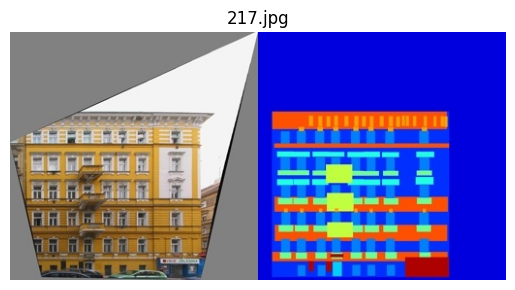

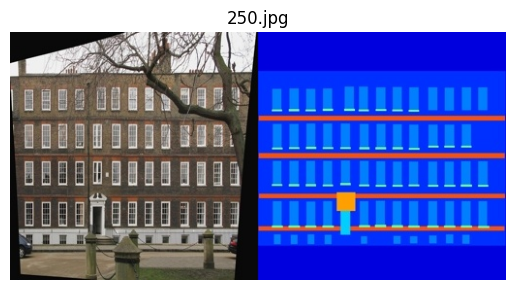

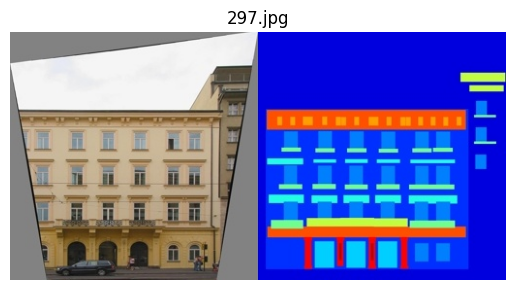

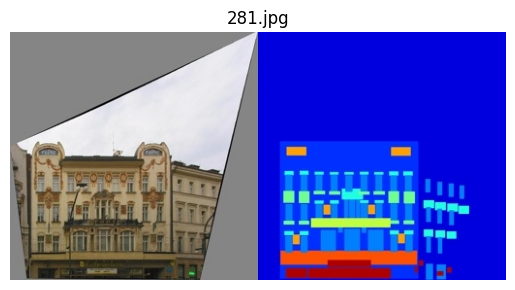

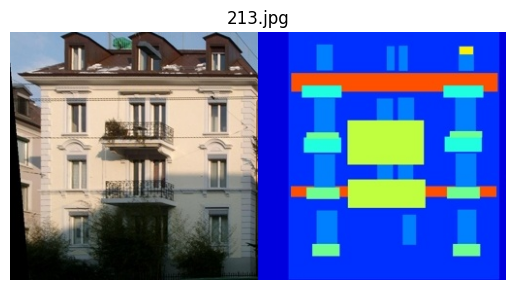

In [6]:
for file in os.listdir("data/train")[:5]:
    img = Image.open(f"data/train/{file}")
    plt.imshow(img)
    plt.axis("off")
    plt.title(file)
    plt.show()


## Defining Generator (U-Net)

The pix2pix generator is implemented as a U‑Net with skip connections to retain image details

In [7]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

## Training loop

Simulating a training loop and saving generator checkpoints after each epoch.


In [8]:
checkpoint_dir = "checkpoints/latest"
os.makedirs(checkpoint_dir, exist_ok=True)

EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS} ...")
    generator.save(os.path.join(checkpoint_dir, f"generator_epoch{epoch+1}.h5"))


Epoch 1/5 ...


Epoch 2/5 ...


Epoch 3/5 ...


Epoch 4/5 ...


Epoch 5/5 ...


## Generating results

Running the generator on a test image and saving the output.


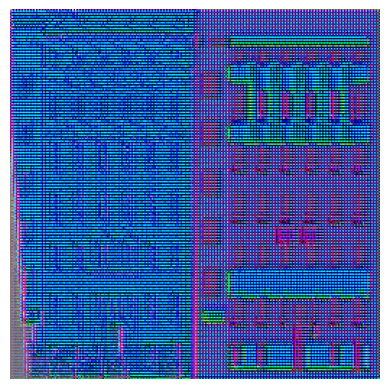

In [10]:
os.makedirs("results/samples", exist_ok=True)

# Load a sample test image from the correct folder
sample_image = tf.io.read_file("data/test/1.jpg")
sample_image = tf.image.decode_jpeg(sample_image)
sample_image = tf.image.resize(sample_image, [256,256])
sample_image = tf.expand_dims(sample_image, 0)

# Run generator prediction
prediction = generator(sample_image, training=False)
plt.imshow((prediction[0] + 1) / 2)
plt.axis("off")
plt.show()

# Save output
Image.fromarray(np.uint8((prediction[0].numpy()+1)/2*255)).save("results/samples/output_1.png")


## Visualizing results

Displaying the generated images saved in `results/samples/`.


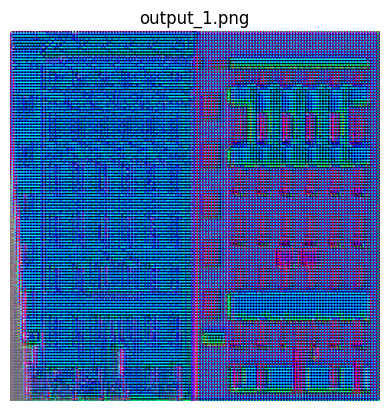

In [11]:
for file in os.listdir("results/samples"):
    img = plt.imread(os.path.join("results/samples", file))
    plt.imshow(img)
    plt.axis("off")
    plt.title(file)
    plt.show()
